Notebook to identify the changes of direction per player

In [105]:

from pathlib import Path
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt, degrees, atan ,atan2, acos
import matplotlib.pyplot as plt


In [2]:
# define the path to the parquet files containing floodlight data: velocity
xy_path = Path("floodlight_parquets/xy_HT1")

In [3]:
# read the velocity data
xy_df = pl.read_parquet(xy_path)

In [4]:
xy_df

C. Coosemans_x,C. Coosemans_y,Amuzu_x,Amuzu_y,M. Rits_x,M. Rits_y,T. Leoni_x,T. Leoni_y,K. Dolberg_x,K. Dolberg_y,K. Sardella_x,K. Sardella_y,A. Dreyer_x,A. Dreyer_y,L. Dendoncker_x,L. Dendoncker_y,J. Simić_x,J. Simić_y,Amando Lapage_x,Amando Lapage_y,Ali Maamar_x,Ali Maamar_y,L. Vázquez_x,L. Vázquez_y,Y. Verschaeren_x,Y. Verschaeren_y,N. Engwanda_x,N. Engwanda_y,Mads Kikkenborg_x,Mads Kikkenborg_y,S. Edozie_x,S. Edozie_y,Thorgan Hazard_x,Thorgan Hazard_y,T. Degreef_x,T. Degreef_y,Thomas Foket_x,Thomas Foket_y,Timon Vanhoutte_x,Timon Vanhoutte_y,Anas Tajaouart_x,Anas Tajaouart_y
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
-46.38,-0.06,-0.57,9.02,-12.86,-10.79,-11.02,5.16,-8.04,-3.84,-19.56,-25.26,-8.72,-22.04,-21.03,-7.13,-23.0,-14.83,-21.15,1.56,-19.85,7.59,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-46.36,-0.06,-0.56,8.96,-12.85,-10.81,-11.06,5.15,-7.99,-3.91,-19.56,-25.25,-8.69,-22.04,-21.04,-7.14,-23.02,-14.83,-21.16,1.56,-19.84,7.59,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-46.35,-0.08,-0.55,8.9,-12.84,-10.82,-11.1,5.15,-7.94,-3.98,-19.56,-25.24,-8.67,-22.04,-21.05,-7.15,-23.03,-14.84,-21.18,1.55,-19.83,7.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-46.34,-0.1,-0.53,8.83,-12.85,-10.84,-11.14,5.15,-7.89,-4.06,-19.57,-25.23,-8.64,-22.04,-21.06,-7.17,-23.05,-14.84,-21.19,1.54,-19.82,7.59,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-46.32,-0.1,-0.5,8.75,-12.85,-10.85,-11.18,5.16,-7.84,-4.13,-19.57,-25.22,-8.63,-22.04,-21.07,-7.19,-23.06,-14.84,-21.21,1.53,-19.81,7.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
-19.59,-8.61,19.71,21.62,15.03,20.27,0.48,9.98,18.87,19.47,-2.01,-9.16,15.57,13.18,0.45,9.08,-2.49,-8.64,-0.86,12.13,-0.25,20.91,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-19.62,-8.59,19.71,21.62,15.0,20.21,0.48,9.96,18.87,19.45,-2.02,-9.17,15.57,13.17,0.44,9.07,-2.49,-8.64,-0.85,12.09,-0.24,20.89,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-19.66,-8.57,19.71,21.62,14.96,20.14,0.49,9.95,18.87,19.42,-2.03,-9.18,15.57,13.16,0.44,9.05,-2.49,-8.64,-0.84,12.04,-0.23,20.86,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# loop over player XY values
# store as tuple
# get angle changes,
# get some sort of cutoff in angle changes

In [6]:
x = xy_df.get_column("Amuzu_x").to_list()
y = xy_df.get_column("Amuzu_y").to_list()

In [7]:
print(min(x))
print(max(x))
print(min(y))
print(max(y))

-43.17
50.33
-32.25
34.55


In [8]:
y

[9.02,
 8.96,
 8.9,
 8.83,
 8.75,
 8.66,
 8.58,
 8.49,
 8.4,
 8.3,
 8.2,
 8.09,
 7.99,
 7.88,
 7.76,
 7.63,
 7.5,
 7.38,
 7.25,
 7.12,
 6.99,
 6.86,
 6.73,
 6.6,
 6.46,
 6.33,
 6.19,
 6.06,
 5.92,
 5.78,
 5.64,
 5.51,
 5.37,
 5.23,
 5.09,
 4.95,
 4.8,
 4.65,
 4.5,
 4.35,
 4.2,
 4.06,
 3.91,
 3.77,
 3.63,
 3.5,
 3.37,
 3.25,
 3.14,
 3.04,
 2.95,
 2.87,
 2.79,
 2.72,
 2.66,
 2.61,
 2.55,
 2.5,
 2.45,
 2.4,
 2.36,
 2.3,
 2.25,
 2.18,
 2.11,
 2.04,
 1.96,
 1.86,
 1.76,
 1.65,
 1.53,
 1.41,
 1.28,
 1.14,
 1.0,
 0.84,
 0.68,
 0.52,
 0.35,
 0.17,
 -0.02,
 -0.21,
 -0.4,
 -0.6,
 -0.8,
 -1.01,
 -1.22,
 -1.43,
 -1.65,
 -1.86,
 -2.08,
 -2.31,
 -2.52,
 -2.75,
 -2.97,
 -3.2,
 -3.42,
 -3.64,
 -3.87,
 -4.09,
 -4.3,
 -4.52,
 -4.73,
 -4.94,
 -5.15,
 -5.36,
 -5.57,
 -5.77,
 -5.97,
 -6.17,
 -6.37,
 -6.55,
 -6.74,
 -6.93,
 -7.11,
 -7.29,
 -7.47,
 -7.65,
 -7.81,
 -7.98,
 -8.13,
 -8.29,
 -8.43,
 -8.58,
 -8.72,
 -8.85,
 -8.98,
 -9.1,
 -9.22,
 -9.33,
 -9.44,
 -9.55,
 -9.65,
 -9.75,
 -9.85,
 -9.93,
 -10.01,
 -1

Kai et al 2021: A new approach to quantify angles and time of changes-of-direction during soccer matches
vragen:
- Moetencoordinaten nog geschaald worden?
- rekenwijzes correct?
- Jerk waarden -- negatief vs de formule

In [9]:
delta_t = 0.04

In [10]:
d_list = [] # store direction of speed

for i in range(len(x)): 
    if i>0 and i<len(x)-1:
        x1=x[i-1]
        y1=y[i-1]
        
        x2=x[i+1]
        y2=y[i+1]
        
        # atan return the arc tangent of x/y in radians
        # degrees converts the arctan to degrees
        d=degrees(atan2(y2 - y1, x2 - x1)) # alternative: arctan
        d_list.append(d)
        
    else: 
        d=0
        d_list.append(d)

#print(min(d_list))    
#print(max(d_list))
d_list

[0,
 -80.53767779197436,
 -77.00538320808356,
 -71.56505117707802,
 -70.55996517182378,
 -64.79887635452492,
 -62.10272896905237,
 -58.57043438516145,
 -55.619655276155065,
 -55.007979801441486,
 -52.69605172201668,
 -52.69605172201645,
 -51.00900595749452,
 -51.95295746817396,
 -52.76516601842533,
 -52.43140797117248,
 -51.34019174590991,
 -48.65222278030634,
 -47.290610042638505,
 -47.290610042638505,
 -44.99999999999997,
 -42.878903603338514,
 -42.87890360333862,
 -42.95459151111284,
 -41.987212495816614,
 -41.987212495816614,
 -41.05481377096248,
 -40.15599962491937,
 -41.18592516570958,
 -39.47245984834387,
 -37.64762064010772,
 -38.453709216705896,
 -38.659808254090024,
 -37.87498365109824,
 -37.11686068327029,
 -38.08877288097531,
 -39.03551289874686,
 -38.290163192243064,
 -38.29016319224314,
 -37.56859202882747,
 -35.94211187138232,
 -36.63411387596744,
 -36.634113875967394,
 -34.33021719550334,
 -33.36636600105955,
 -32.3806777065692,
 -30.762719534238922,
 -28.14160123226173

In [11]:
len(x)

76366

In [12]:
v_list = [] # store speed

for i in range(len(x)): 
    if i!=0 and i<len(x)-1:
        vx=(x[i+1]-x[i-1])**2
        vy=(y[i+1]-y[i-1])**2
        
        v=sqrt((vx+vy)/(delta_t*2))
        
    else: 
        v=0
    v_list.append(v)
    
    #print(v)
print(min(v_list))    
print(max(v_list))

0
2.606961833245742


In [13]:
len(v_list)

76366

In [14]:
# not the standard formula --> takes the centered difference
a_list = []
for i in range(len(v_list)):
    if i!=0 and i<len(v_list)-1:
        v1=abs(v_list[i-1]) #v_list[i-1]#
        v2=abs(v_list[i+1]) # v_list[i+1]#
        
        a=sqrt((((v2-v1)**2)/(delta_t*2)))
        #a=((v2-v1)**2)/(delta_t*2)
        
    else: 
        a=0
    
    a_list.append(a)
    
    #print(a)
    
print(min(a_list))    
print(max(a_list))
a_list

0
1.6677080080158013


[0,
 1.6677080080158013,
 0.45573290503069647,
 0.585761539149191,
 0.37211324090174974,
 0.1509534605439248,
 0.2883411102091292,
 0.47329310059641216,
 0.4147610152173158,
 0.42237858730570055,
 0.24845579167757595,
 0.07721932591554388,
 0.3506757710165508,
 0.5477655955003213,
 0.4495344000866157,
 0.07687303136863485,
 0.062401584622499666,
 0.4209988548430009,
 0.26024505190185243,
 0.17324257447402583,
 0.35329179039716835,
 0.18004921592314882,
 0.17665989540404015,
 0.2688657240169322,
 0.09220582861289836,
 0.09359218012098297,
 0.18849633621194678,
 0.17637170859369872,
 0.2720735325217261,
 0.210436119957767,
 0.07860554986320832,
 0.07722468142865184,
 0.27380378897258795,
 0.19732017130635465,
 0.17545251127589012,
 0.15419880284718335,
 0.17552958168351965,
 0.09760653654783007,
 0.09859808161617155,
 0.12395044506271047,
 0.07540585995984107,
 0.10075822340638942,
 0.13104435354177724,
 0.061417414205362154,
 0.13747774668402987,
 0.026794149391822106,
 0.02697462314912

In [15]:
print(len(a_list))
count = sum(1 for x in a_list if x > 8 or x < -8)
print(count)

76366
0


In [16]:
# calculate jerk
j_list = []
for i in range(len(a_list)):
    if i>0 and i<len(x)-1:
        a1=abs(a_list[i-1])
        a2=abs(a_list[i+1])
        
        #j=sqrt(((a2-a1)**2)/(2*delta_t))
        j=((a2-a1))/(2*delta_t)
        
    else: 
        j=0
    
    j_list.append(j)

print(min(j_list))    
print(max(j_list))
j_list

-13.524330860832627
7.766583803240115


[0,
 5.696661312883705,
 -13.524330860832627,
 -1.045245801611834,
 -5.435100982565828,
 -1.0471516336577564,
 4.029245500656092,
 1.580248812602332,
 -0.6364314161338952,
 -2.078815294246748,
 -4.314490767376959,
 1.2777497417371855,
 5.8818283698097185,
 1.2357328633758116,
 -5.88615705164608,
 -4.83916019330145,
 4.3015727934295755,
 2.4730433409919095,
 -3.0969535046121885,
 1.1630842311914489,
 0.08508301811403739,
 -2.2078986874141027,
 1.1102063511722924,
 -1.0556758348892723,
 -2.1909192986993653,
 1.2036313449881053,
 1.0347441059089468,
 1.0447149538722416,
 0.4258051420508536,
 -2.418349783231472,
 -1.6651429816139394,
 2.4399779888672453,
 1.501193623471285,
 -1.2293909712087228,
 -0.5390171057396413,
 0.0009633800953690735,
 -0.707403328741916,
 -0.9616437508418513,
 0.32929885643600504,
 -0.28990277070413095,
 -0.28990277070401316,
 0.695481169774202,
 -0.4917601150128408,
 0.08041741427815795,
 -0.4327908101692506,
 -1.3812890441863346,
 -0.1428789511412745,
 0.971744547

In [17]:
len(j_list)

76366

In [18]:
# count the number of COD's
# add angle change
cod_counter = 0

for i, v, d in zip(range(len(j_list)), range(len(v_list)), range(len(d_list))):
    print(j_list[i])
    
    if v_list[v-1]> 3:
        if abs(d_list[i-1] - d_list[i+1]) > 20: 
            if (j_list[i-1]<0 and j_list[i+1]>0) or (j_list[i-1]>0 and j_list[i+1]<0):
                cod_counter += 1
            else: continue
        else: continue
    else: continue
    
print(cod_counter)
    

0
5.696661312883705
-13.524330860832627
-1.045245801611834
-5.435100982565828
-1.0471516336577564
4.029245500656092
1.580248812602332
-0.6364314161338952
-2.078815294246748
-4.314490767376959
1.2777497417371855
5.8818283698097185
1.2357328633758116
-5.88615705164608
-4.83916019330145
4.3015727934295755
2.4730433409919095
-3.0969535046121885
1.1630842311914489
0.08508301811403739
-2.2078986874141027
1.1102063511722924
-1.0556758348892723
-2.1909192986993653
1.2036313449881053
1.0347441059089468
1.0447149538722416
0.4258051420508536
-2.418349783231472
-1.6651429816139394
2.4399779888672453
1.501193623471285
-1.2293909712087228
-0.5390171057396413
0.0009633800953690735
-0.707403328741916
-0.9616437508418513
0.32929885643600504
-0.28990277070413095
-0.28990277070401316
0.695481169774202
-0.4917601150128408
0.08041741427815795
-0.4327908101692506
-1.3812890441863346
-0.1428789511412745
0.971744547603677
2.2838603848568204
-1.0476583990789072
-0.5790708740371957
-0.19586602252906113
-0.19848

Brenda et al 2022: Quantifying change of direction load using positional data from small-sided games in soccer
- Zijn de windows juist (hoek 1e en laatste meting) - of zou dit anders moeten
- Hoe hoeding change berekenen, denk dat ik de foute kant op ga

In [19]:
xNoZero = [value+45 for value in x]

In [20]:
print(min(xNoZero))
print(max(xNoZero))

1.8299999999999983
95.33


In [21]:
print(25*0.04)

1.0


In [22]:
# calculating the heading angle (ha)
ha_list = []

for i in range(len(xNoZero)): 
    ha = degrees(atan(y[i]/xNoZero[i]))
    
    ha_list.append(ha)
    


In [23]:
print(min(ha_list))
print(max(ha_list))

-78.32987768915552
83.750437377355


In [24]:
ha_list

[11.475992364082071,
 11.399162721247484,
 11.32232610988858,
 11.230623547061288,
 11.124108975782233,
 11.005262790184794,
 10.894107264175751,
 10.77308631019938,
 10.645197810990808,
 10.507523039381253,
 10.365568525079661,
 10.211635204252655,
 10.07044728477999,
 9.915146214605658,
 9.747997197499489,
 9.56696254845013,
 9.38653418408797,
 9.218990417524193,
 9.03586126637286,
 8.853508741789513,
 8.671931584610581,
 8.487488097960766,
 8.303988859782839,
 8.12143037306387,
 7.92600667745217,
 7.743743750961491,
 7.550438632198706,
 7.368673101341876,
 7.176001901384211,
 6.98447586373255,
 6.791246728761676,
 6.612598541684594,
 6.4232347804362036,
 6.2337844822402255,
 6.045617863780224,
 5.857520140068591,
 5.6602206597997835,
 5.463132004179279,
 5.267449477099965,
 5.073162600467301,
 4.879273783006726,
 4.698364886765789,
 4.508247246561741,
 4.33006028458947,
 4.152388404168549,
 3.988271644394812,
 3.824635990074252,
 3.6735687784089546,
 3.534235056472318,
 3.4072424434

In [25]:
# Player velocity in the x–y plane was calculated for each sample  
v_list = [] # store speed

for i,j in zip(range(len(x))): 
    if i!=0 and i<=len(x):
        vx=(x[i]-x[i-1])**2
        vy=(y[i]-y[i-1])**2
        
        v=sqrt(((vx+vy)/delta_t))
        
    else: 
        v=0
    v_list.append(v)
    
    #print(v)
print(min(v_list))    
print(max(v_list))



0
1.8500000000000008


In [26]:
#v_list

In [58]:
# Convert to radians for unwrapping later
ha_radians = np.radians(ha_list)#np.unwrap works better oin radians

window_size = 25

rolling_avg_v_25 = []
heading_change_25 = []

for i, j in zip(range(len(v_list)), range(len(ha_radians))):
    if i >= window_size:
        # average velocity
        window = v_list[i-window_size:i]
        avg_v = sum(window) / window_size 
        
        # heading_change%
        window_angles = ha_radians[j-window_size:j]
        unwrapped = np.unwrap(window_angles) # Unwrap by taking the complement of large deltas with respect to the period --> adjusts the angles so they form a continuous curve — preserving the actual direction of turning
        heading_change = unwrapped[-1] - unwrapped[0] # heading change in radians
        heading_change_deg = degrees(heading_change)  # Convert to degrees        
        
    else:
        avg_v = 0  
        heading_change_deg = 0
        
    heading_change_25.append(heading_change_deg)
    rolling_avg_v_25.append(avg_v)

In [97]:
heading_change_25

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 -3.5499856866299013,
 -3.655418970285994,
 -3.7718874776898743,
 -3.8619504457194127,
 -3.9481070743980227,
 -4.020786926452244,
 -4.1028605354140755,
 -4.160487768514786,
 -4.221963030554605,
 -4.273738557141027,
 -4.319950661299437,
 -4.354115064184064,
 -4.410226624980206,
 -4.452014210426379,
 -4.480547720399524,
 -4.493799947982829,
 -4.507260401081245,
 -4.520625530758404,
 -4.52761401981112,
 -4.523448457200044,
 -4.519543180442032,
 -4.499216453565954,
 -4.479352869708588,
 -4.447861594654916,
 -4.391771620979852,
 -4.336501307517577,
 -4.257995865937952,
 -4.178984265063926,
 -4.088808865323515,
 -3.9878938808186186,
 -3.8735419982834216,
 -3.762186608984685,
 -3.650918037026002,
 -3.528057564873594,
 -3.405390360147613,
 -3.282716102839264,
 -3.1395940133006373,
 -3.016991265149842,
 -2.885030879812409,
 -2.7749702964720746,
 -2.6641709983735447,
 -2.5656631065253364,
 -2.4676

In [95]:
# velocity and curvature dependend cutoff
ha25_radians = np.radians(heading_change_25)
k = 0.2

cutoff_list = [1 / (k * hc) if hc != 0 else 0 for hc in ha25_radians]


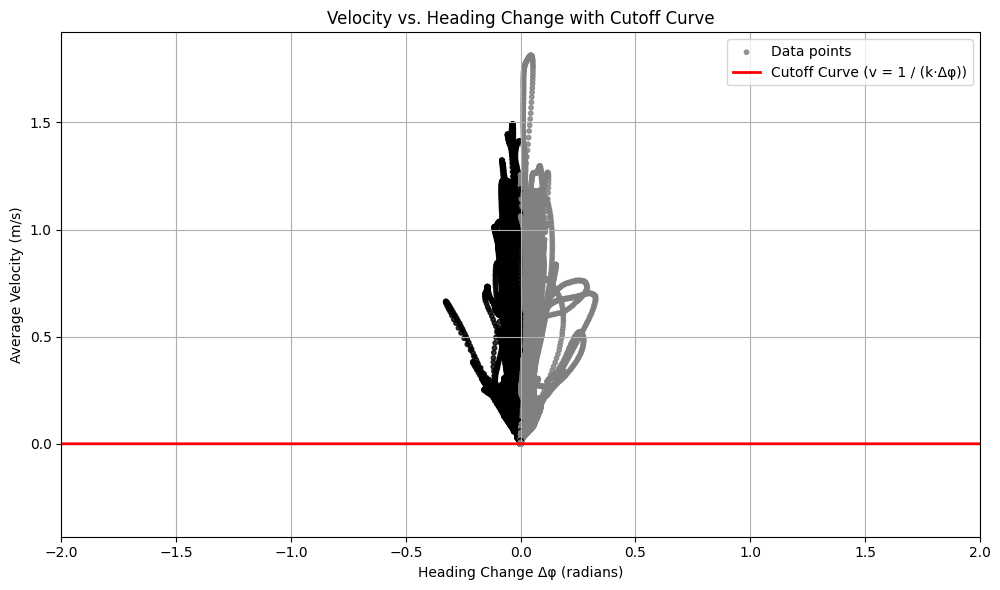

In [94]:
# CHTGPT suggestion
# Constants and data
k = 0.15
ha25_radians = np.radians(heading_change_25)
v_vals = rolling_avg_v_25
phi_vals = ha25_radians

# Compute cutoff curve: v = 1 / (k * Δphi)
cutoff_vals = [1 / (k * phi) if phi != 0 else float('inf') for phi in phi_vals]

# Prepare colors based on whether each point is above or below the curve
colors = ['black' if v > cutoff else 'gray' for v, cutoff in zip(v_vals, cutoff_vals)]

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(phi_vals, v_vals, c=colors, s=10, alpha=0.8, label='Data points')

# Optional: Overlay the cutoff curve
phi_range = np.linspace(min(phi_vals), max(phi_vals), 300)
cutoff_curve = 1 / (k * phi_range)
plt.plot(cutoff_curve, phi_range, color='red', linewidth=2, label='Cutoff Curve (v = 1 / (k·Δφ))')

# Labels and legend
plt.xlabel("Heading Change Δφ (radians)")
plt.ylabel("Average Velocity (m/s)")
plt.title("Velocity vs. Heading Change with Cutoff Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xlim(-2, 2)
plt.show()

In [96]:
cutoff_vals

[inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 np.float64(-107.59814183452814),
 np.float64(-104.49468762007984),
 np.float64(-101.26809606062025),
 np.float64(-98.90646417898152),
 np.float64(-96.7481013616605),
 np.float64(-94.99928009305958),
 np.float64(-93.09891479945195),
 np.float64(-91.8093946366547),
 np.float64(-90.47257416898137),
 np.float64(-89.37651620787815),
 np.float64(-88.42042267808031),
 np.float64(-87.7266351003354),
 np.float64(-86.61048419983706),
 np.float64(-85.79753912869172),
 np.float64(-85.2511539340304),
 np.float64(-84.999748062218),
 np.float64(-84.7459053683514),
 np.float64(-84.4953559682408),
 np.float64(-84.36493520631065),
 np.float64(-84.44262536308072),
 np.float64(-84.51559110520331),
 np.float64(-84.89741877562004),
 np.float64(-85.2738943617538),
 np.float64(-85.8776414894681),
 np.float64(-86.97443682996585),
 np.float64(-88.08295820374327),

In [87]:
cutoff_list

[inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 np.float64(-80.69860637589609),
 np.float64(-78.37101571505988),
 np.float64(-75.95107204546518),
 np.float64(-74.17984813423614),
 np.float64(-72.56107602124538),
 np.float64(-71.24946006979467),
 np.float64(-69.82418609958896),
 np.float64(-68.85704597749101),
 np.float64(-67.85443062673602),
 np.float64(-67.03238715590861),
 np.float64(-66.31531700856023),
 np.float64(-65.79497632525155),
 np.float64(-64.9578631498778),
 np.float64(-64.34815434651878),
 np.float64(-63.938365450522795),
 np.float64(-63.7498110466635),
 np.float64(-63.559429026263544),
 np.float64(-63.371516976180594),
 np.float64(-63.27370140473298),
 np.float64(-63.33196902231053),
 np.float64(-63.38669332890247),
 np.float64(-63.67306408171501),
 np.float64(-63.95542077131533),
 np.float64(-64.40823111710107),
 np.float64(-65.2308276224744),
 np.float64(-66.062218652

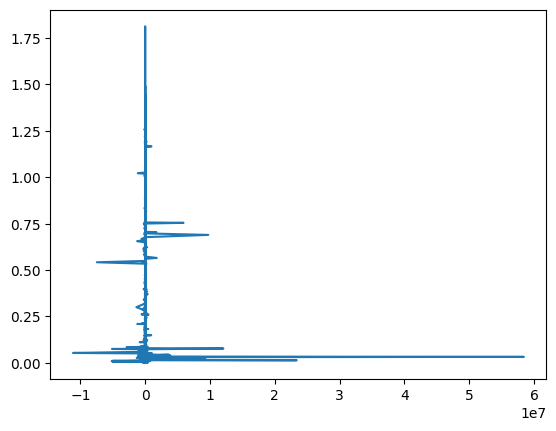

In [88]:

#plt.plot(cutoff_list)
plt.plot(cutoff_list, rolling_avg_v_25)

In [39]:
unwrapped

array([0.3224458, 0.3224458, 0.3224458, 0.3224458, 0.3224458, 0.3224458,
       0.3224458, 0.3224458, 0.3224458, 0.3224458, 0.3224458, 0.3224458,
       0.3224458, 0.3224458, 0.3224458, 0.3224458, 0.3224458, 0.3224458,
       0.3224458, 0.3224458, 0.3224458, 0.3224458, 0.3224458, 0.3224458,
       0.3224458])

In [59]:
len(heading_change_25)

76366

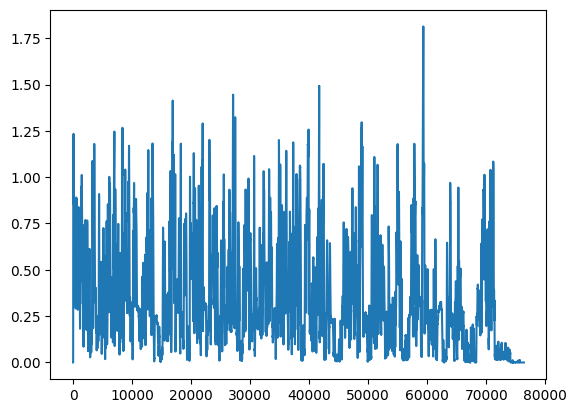

In [66]:
plt.plot(rolling_avg_v_25)

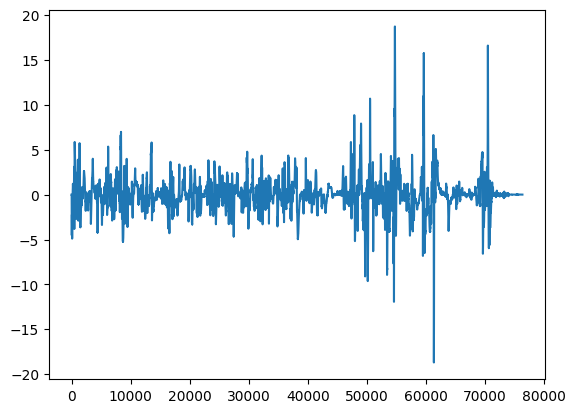

In [65]:
plt.plot(heading_change_25)

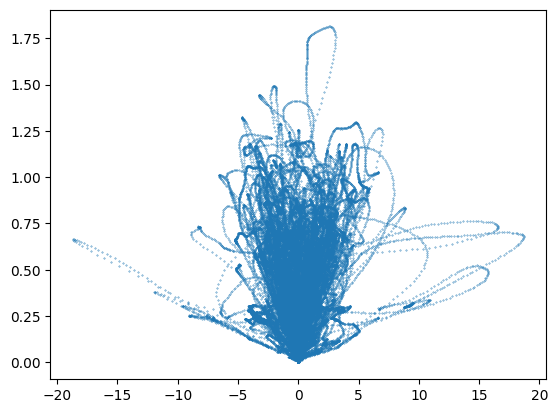

In [60]:
plt.scatter(heading_change_25,rolling_avg_v_25, s= 0.1)

Reilly et al. 2021:  Automated Classification of Changes of Direction in Soccer Using Inertial Measurement Units
- average time bbetween start & end COD = 3.1s
- COD angle as one of ‘0–45 DEG’, ‘45–90 DEG’, ‘90–135 DEG’, ‘135–180DEG’
- extra machine learning model based on video analysis

In [98]:
print(x)
print(y)

[-0.57, -0.56, -0.55, -0.53, -0.5, -0.47, -0.42, -0.38, -0.31, -0.25, -0.17, -0.09, -0.01, 0.08, 0.17, 0.27, 0.37, 0.47, 0.59, 0.71, 0.83, 0.97, 1.11, 1.25, 1.4, 1.55, 1.7, 1.86, 2.02, 2.18, 2.36, 2.53, 2.7, 2.88, 3.06, 3.25, 3.43, 3.62, 3.81, 4.0, 4.2, 4.4, 4.59, 4.79, 5.0, 5.2, 5.41, 5.62, 5.84, 6.06, 6.28, 6.5, 6.73, 6.96, 7.19, 7.42, 7.66, 7.9, 8.13, 8.37, 8.61, 8.84, 9.08, 9.32, 9.55, 9.78, 10.01, 10.24, 10.46, 10.68, 10.9, 11.11, 11.32, 11.52, 11.72, 11.91, 12.1, 12.28, 12.46, 12.63, 12.79, 12.95, 13.1, 13.25, 13.39, 13.53, 13.66, 13.79, 13.91, 14.03, 14.14, 14.24, 14.34, 14.44, 14.53, 14.61, 14.69, 14.75, 14.82, 14.88, 14.93, 14.98, 15.02, 15.05, 15.08, 15.09, 15.11, 15.11, 15.11, 15.1, 15.09, 15.07, 15.04, 15.0, 14.97, 14.92, 14.86, 14.8, 14.74, 14.67, 14.59, 14.51, 14.42, 14.32, 14.22, 14.12, 14.01, 13.89, 13.77, 13.65, 13.52, 13.39, 13.26, 13.12, 12.98, 12.83, 12.68, 12.53, 12.38, 12.22, 12.06, 11.9, 11.74, 11.58, 11.41, 11.24, 11.07, 10.9, 10.72, 10.55, 10.37, 10.2, 10.02, 9

In [116]:
counter = 0
loop_counter = 0

for i, j in zip(x,y):
    loop_counter += 1
    
    if loop_counter > counter and loop_counter < len(x):
        
        x1=sum(x[counter:counter+9])/10
        y1=sum(y[counter:counter+9])/10
        
        x2=sum(x[counter+24:counter+34])/10
        y2=sum(y[counter+24:counter+34])/10
        
        x3=sum(x[-10:])/10
        y3=sum(y[-10:])/10
        
        a=sqrt(((x2-x3)**2)+((y2-y3)**2)) # distance between 2nd and 3th points cluster
        b=sqrt(((x1-x3)**2)+((y1-y3)**2)) # distance between 1st and 3th points cluster
        c=sqrt(((x1-x2)**2)+((y1-y2)**2)) # distance between 1st and 2nd points cluster
        
        if a != 0 and c != 0:
            cod=180-(degrees(acos(((a**2)+(c**2)-(b**2))/(2*a*c))))
        else:
            print("Skipped due to zero distance between clusters.")
        print(cod)
        counter += 60
    
    elif loop_counter <= counter and loop_counter < len(x):
        continue
    
    else:
        break
    
    

80.155035789219
110.38185914285393
158.53706494630802
119.54520223667978
133.54572494960826
143.7666750292543
143.63310887574661
121.65305705006094
34.58324557286289
32.79862972669028
33.9127712914281
91.58900101322882
36.0027442307009
131.18261779994455
176.84356493834312
166.2042288027247
163.8721710732056
153.17298557718047
56.17555517217953
173.3298508937367
45.197220130126595
3.9208044601215306
81.21973448022598
102.41427774498804
28.187483420162124
34.17210766020028
84.38466591605744
109.71855101513306
116.80018536539504
78.03423469123162
70.71685013540949
116.68797641281742
115.68641005172158
119.02239887993656
88.29598293371173
112.53092124296624
162.02582545501943
168.7124922966661
131.95496526499588
141.54566271801994
169.56213890479245
172.45602449145957
171.53684330838064
177.29017749573384
174.47800021258652
177.7289130025266
174.4841627925016
158.80514290855106
130.58122709808214
144.9211149861914
120.2806667423407
126.2455652111093
125.07613289254613
130.6191438725182
17

In [ ]:
vx=(x[i+1]-x[i-1])**2
vy=(y[i+1]-y[i-1])**2
        
        v=sqrt((vx+vy)/(delta_t*2))

new approach?

In [22]:
# --> PROBLEM: calculates angle to the origin, not the previous frame
# calculates the angle in radians
theta = np.arctan2(y, x)
# converts the radian angle to degrees
degrees = np.degrees(theta)
degrees

array([93.6158787 , 93.57633437, 93.53625339, ..., 47.64595046,
       47.64595046, 47.64595046], shape=(76366,))

In [41]:
tuple_list = list(zip(x, y))
#tuple_list

In [44]:
numpy_tuple = np.array(tuple_list)
# numpy_tuple

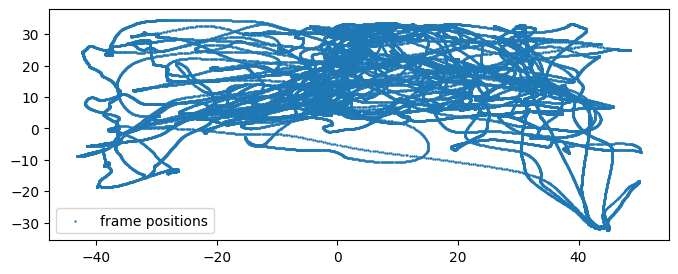

In [50]:
data = tuple_list

xy = np.array(data)

fig = plt.figure(figsize=(8,3))
ax = plt.gca()
X = np.linspace(0, 3, 100)
Y = np.linspace(3, 5, 100)
sc1 = ax.scatter(*xy.T, s=0.5)
plt.legend([sc1], ['frame positions'])
plt.show()